In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
path = "sonnets.txt"

In [3]:
with open(path , "r" , encoding='utf-8') as f:
    text = f.read()
print(text[ : 300])

FROM fairest creatures we desire increase,
That thereby beauty's rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou, contracted to thine own bright eyes,
Feed'st thy light'st flame with self-substantial fuel,
Making a famine where abundance


In [4]:
chars = sorted(list(set("".join(text))))
len(chars) 

60

In [5]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] 
decode = lambda l: ''.join([itos[i] for i in l])

In [6]:
data = encode(text)
data = np.array(data)
n = int(0.9 * len(data))
train_data = data[ : n]
val_data = data[n : ]

In [7]:
train_data.shape , val_data.shape

((84220,), (9358,))

In [8]:
train_data[ : 40]

array([15, 26, 24, 22,  1, 39, 34, 42, 51, 38, 52, 53,  1, 36, 51, 38, 34,
       53, 54, 51, 38, 52,  1, 56, 38,  1, 37, 38, 52, 42, 51, 38,  1, 42,
       47, 36, 51, 38, 34, 52])

In [9]:
context_length = 128
batch_size = 32

In [10]:
def get_batch(split):
  data = train_data if split == "train" else val_data
  ix = tf.cast(tf.random.uniform( shape = (batch_size,), minval = 0, maxval = len(data)-context_length) , dtype=tf.int64) # 4 random int btw 0 and len(train_data)
  x = tf.stack([data[i : i+context_length] for i in ix])
  y = tf.stack([data[i+1 : i+context_length+1] for i in ix])
  return x , y

In [11]:
xb , yb = get_batch("train")
xb.shape , yb.shape

(TensorShape([32, 128]), TensorShape([32, 128]))

In [19]:
# num_batches = 10000
# x_batches = []
# y_batches = []

# for i in range(num_batches):
#     xb, yb = get_batch(i , "train")
#     x_batches.append(xb)
#     y_batches.append(yb)

# x_var = tf.reshape(x_batches , (num_batches , -1))
# y_var = tf.reshape(y_batches , (num_batches , -1))
# print(x_var.shape)

In [20]:
# num_batches = 1500
# x_batches = []
# y_batches = []

# for i in range(num_batches):
#     xb, yb = get_batch(i , "val")
#     x_batches.append(xb)
#     y_batches.append(yb)

# x_val = tf.reshape(x_batches , (num_batches , -1))
# y_val = tf.reshape(y_batches , (num_batches , -1))

# print(x_val.shape)

### Hyperparameters

In [75]:
emb_dim = 384
context_length = 128 #T
batch_size = 32 #B
vocab_size = len(chars)
dk = 64
epochs = 50
dropout = 0.2
n_heads = 6
Nx = 4
lr = 4e-5

### Compilers

In [76]:
initializer = tf.keras.initializers.HeNormal()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

tril = tf.Variable(tf.keras.ops.tril(tf.ones((context_length,context_length))) , trainable = False) 
mask = (tril == 0)

### Parameters

In [48]:
token_emb = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, emb_dim, input_shape=(context_length,))
])  # (B, T, emb_dim)
pos_emb = tf.keras.Sequential([
    tf.keras.layers.Embedding(context_length, emb_dim, input_shape=())
])  # (T, emb_dim)


WQ = [[tf.Variable(initializer(shape=(emb_dim, dk)), trainable=True) 
       for _ in range(n_heads)] for _ in range(Nx)]
WK = [[tf.Variable(initializer(shape=(emb_dim, dk)), trainable=True) 
       for _ in range(n_heads)] for _ in range(Nx)]
WV = [[tf.Variable(initializer(shape=(emb_dim, dk)), trainable=True) 
       for _ in range(n_heads)] for _ in range(Nx)]
WO = [tf.Variable(initializer(shape=(n_heads * dk, emb_dim)), trainable=True) 
      for _ in range(Nx)]


ln1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(context_length , emb_dim)),
    tf.keras.layers.LayerNormalization()
])
ln2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(context_length , emb_dim)),
    tf.keras.layers.LayerNormalization()
])


ffwd = [tf.keras.Sequential([
        tf.keras.layers.Input(shape=(context_length , emb_dim)),
        tf.keras.layers.Dense(4 * emb_dim),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(emb_dim),
        tf.keras.layers.Dropout(dropout)
    ]) for _ in range(Nx)]

ln_block = [tf.keras.Sequential([
    tf.keras.layers.Input(shape=(context_length , emb_dim)),
    tf.keras.layers.LayerNormalization()
]) for _ in range(Nx)]

lm_head = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(context_length , emb_dim)),
    tf.keras.layers.Dense(vocab_size),
    tf.keras.layers.ReLU(),
])


In [49]:
parameters = (token_emb.trainable_variables + pos_emb.trainable_variables +
             [w for block in WQ for w in block] +
             [w for block in WK for w in block] +
             [w for block in WV for w in block] +
             WO +
             [p for f in ffwd for p in f.trainable_variables] +
             lm_head.trainable_variables +
             [p for ln in ln_block for p in ln.trainable_variables] +
             ln1.trainable_variables + ln2.trainable_variables)

no_params = sum(tf.size(p).numpy() for p in parameters) /1e6
print("Total number of parameters:", no_params,"M")

Total number of parameters: 7.185468 M


### Transformer Block & Masked Multi-Head Self Attention Implementation

In [50]:
def transformer_block(x , enc ,  block_id ,  ln_block , ffwd):
    multi_attention_score = [] 
    for head in range(n_heads):
        
        key = x @ WK[block_id][head] 
        query = x @ WQ[block_id][head]
        value = x @ WV[block_id][head]
        wei = query @ tf.transpose(key , perm=[0,2,1]) 
        wei = wei / tf.math.sqrt(tf.cast(dk , tf.float32))
        wei = tf.where(mask , float('-inf') , wei)
        wei = tf.nn.softmax(wei , axis = -1)  
        wei = tf.keras.layers.Dropout(dropout)(wei)        
        out = wei @ value 
        multi_attention_score.append(out) 
    concatenated = tf.concat(multi_attention_score , axis=-1) 
    output = concatenated @ WO[block_id] 
    output = tf.keras.layers.Dropout(dropout)(output)
  
    attn_out = output + enc 
    x = ln_block[block_id](attn_out)
    ffn_out = attn_out + ffwd[block_id](x) 
    return ffn_out

### Forward Pass of Transformer

In [51]:
def forward_pass(x):
    te = token_emb(x)
    pe = pos_emb(tf.range(context_length)) 
    enc = te + pe
    x = ln1(enc)
    for i in range(Nx):
            x = transformer_block(x , enc , i , ln_block , ffwd)
    x = ln2(x) 
    logits = lm_head(x) 
    return logits

### Loss and Validation Loss Calculation 

In [52]:
def loss_calculation(logits , Yb):
    logits_flat = tf.reshape(logits, (-1, logits.shape[2]))  
    targets_flat = tf.reshape(Yb, (-1,))  
    loss = loss_fn(targets_flat, logits_flat)
    loss = tf.reduce_mean(loss)
    return loss

In [53]:
val_losses = []
def validation():
    # ix = tf.keras.random.randint(shape=(batch_size,) , minval=0 , maxval=x_val.shape[0])
    # Xb , Yb = tf.gather(x_val , ix) , tf.gather(y_val , ix)
    Xb , Yb = get_batch("val") 
    logits = forward_pass(Xb) 
    loss = loss_calculation(logits , Yb)
    val_losses.append(loss)
    return loss

In [77]:
losses = []
for epoch in range(epochs):
    # ix = tf.keras.random.randint(shape=(batch_size,) , minval=0 , maxval=x_var.shape[0])
    # Xb , Yb = tf.gather(x_var , ix) , tf.gather(y_var , ix)
    Xb , Yb = get_batch("train") 
    with tf.GradientTape() as tape:
        
        # Forward Pass
        
        logits = forward_pass(Xb) 
        
        # Loss calculation
        
        loss = loss_calculation(logits , Yb)

    grads = tape.gradient(loss , parameters)
    optimizer.apply_gradients(zip(grads, parameters))

    losses.append(loss.numpy())
    val_loss = validation()
    
    if epoch % 5 == 0:
      print(f"epoch={epoch}, loss={loss.numpy():.4f} , val_loss={val_loss.numpy():.4f}")

epoch=0, loss=2.3976 , val_loss=2.4547
epoch=5, loss=2.4192 , val_loss=2.4652
epoch=10, loss=2.4346 , val_loss=2.4346
epoch=15, loss=2.4066 , val_loss=2.4608
epoch=20, loss=2.4076 , val_loss=2.4742
epoch=25, loss=2.4254 , val_loss=2.4448
epoch=30, loss=2.4254 , val_loss=2.4432
epoch=35, loss=2.3921 , val_loss=2.4550
epoch=40, loss=2.4092 , val_loss=2.4760
epoch=45, loss=2.4067 , val_loss=2.4518


### Exponential Learning Rate Decay Result
```
lre = tf.linspace(-5, -1, 1000)
lrs = 10 ** lre
lrs = lrs.numpy()
```

In [44]:
optimal_lr = lri[np.argmin(losses) - 5] 
optimal_lr

0.00010023075482838654

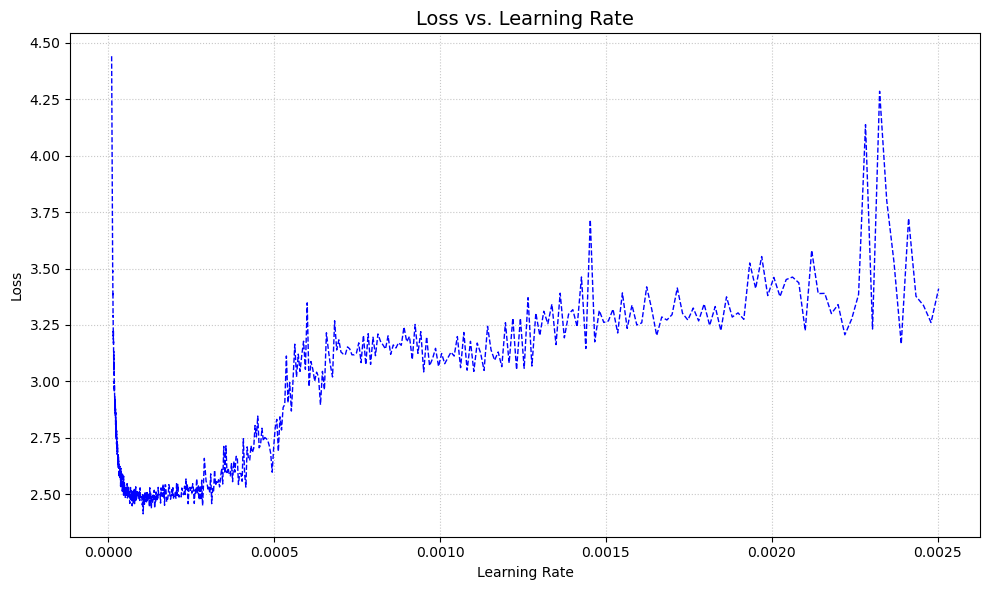

In [37]:
plt.figure(figsize=(10, 6)) 
plt.plot(lri[ : 600], losses[ : 600],
         color='blue',       
         linestyle='--',     
         # marker='o',         
         markersize=6,       
         linewidth=1,        
         label='Training Loss' 
        )

plt.title('Loss vs. Learning Rate', fontsize=14)
plt.xlabel('Learning Rate', fontsize=10)
plt.ylabel('Loss', fontsize=10)

plt.grid(True, linestyle=':', alpha=0.7)

# plt.legend(fontsize=10)
plt.tight_layout() 
plt.show()

In [78]:
losses[-1]

2.4142373

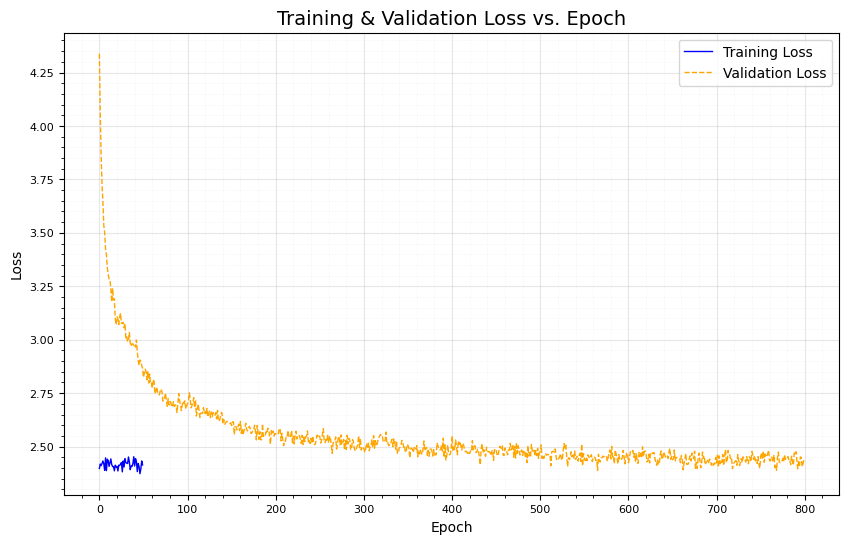

In [79]:
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(losses, linestyle='-',linewidth=1, color='blue', label='Training Loss')

plt.plot(val_losses, linestyle='--',linewidth=1, color='orange', label='Validation Loss')

plt.title('Training & Validation Loss vs. Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.grid(True, alpha=0.3)

plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', alpha=0.2)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8  )

plt.show()

In [80]:
generated = []
context = [0] * context_length  # Start context

for _ in range(50):  # Generate 350 tokens
    Xb = tf.constant([context], dtype=tf.int32)  # Shape (1, T)

    logits = forward_pass(Xb)                     

    # Take the logits at the last position
    last_logits = logits[:, -1, :]              # (1, vocab_size)
    probs = tf.nn.softmax(last_logits, axis=-1) # (1, vocab_size)

    ix = tf.random.categorical(tf.math.log(probs), num_samples=1)[0, 0].numpy()
    context = context[1:] + [ix]  # Slide the context window
    generated.append(ix)


In [81]:
decode(generated)

'I wiR dr nselongr ver thRd py t ineavire,\nI had s '

In [ ]:
lpp